# Job Slot Product Retention Analysis
#### Author                   : Aniruddha Dutta
#### Dtae Created on   : 21 Feb 2020
#### Last Modified on  : 22 Feb 2020
#### version                  : 1.0

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


### Reading input data
Stored original data into two seperate csv files:
1. Sales_performance_data: Containing the job slots sales performance data at a employer_ID, City_ID, Contract_ID level.
2. Location_data: Containing the city to state mapping

Note: Extracted Month and Year from the StartDate to create two new columns in the sales_performance_data for the analysis. This was done in Excel.

In [2]:
sales_perf_data = pd.read_csv("sales_performance_data.csv")
location_data = pd.read_csv("location_data.csv")

In [3]:
sales_perf_data.head(5)

,Employer_ID,City_ID,Contract_ID,StartDate,EndDate,Contract_Duration,Renewal_Flag,Job_Slots,Total_Contract_Value,Applications,Apply_Start_Clicks,Click_Market_Value,Job_Listings,Month,Year,CMV/TCV
0,4277920,9767,2423796,30-10-2017,30-11-2017,31,1,15,995,215,255,15484.40,25,10,2017,15.562211
1,2372987,8585,2074128,29-06-2017,29-07-2017,30,0,50,1495,55,70,1719.30,50,6,2017,1.150033
2,1142693,6665,1924740,02-05-2017,02-06-2017,31,0,15,495,45,95,1195.75,20,5,2017,2.415657
3,1353893,5165,1942512,09-05-2017,06-06-2017,28,0,15,995,155,175,1197.35,20,5,2017,1.203367
4,922427,3882,1380984,19-09-2016,20-10-2016,31,1,15,745,150,185,8889.70,20,9,2016,11.932483


In [4]:
location_data.head(5)

,City_ID,City_Name,State_ID,State_Name
0,1,Rockford,OH,Ohio
1,2,Sedgewickville,MO,Missouri
2,3,Whitehouse,OH,Ohio
3,4,Victor,IA,Iowa
4,5,Pacific Junction,IA,Iowa


### EDA
Merging the two files to create a single analytical data set for Exploratory Data Ananlysis

In [5]:
ads = sales_perf_data.merge(location_data, how = "left", on = "City_ID")
ads.head(5)

,Employer_ID,City_ID,Contract_ID,StartDate,EndDate,Contract_Duration,Renewal_Flag,Job_Slots,Total_Contract_Value,Applications,Apply_Start_Clicks,Click_Market_Value,Job_Listings,Month,Year,CMV/TCV,City_Name,State_ID,State_Name
0,4277920,9767,2423796,30-10-2017,30-11-2017,31,1,15,995,215,255,15484.40,25,10,2017,15.562211,Kaser,NY,New York
1,2372987,8585,2074128,29-06-2017,29-07-2017,30,0,50,1495,55,70,1719.30,50,6,2017,1.150033,Mexico,PA,Pennsylvania
2,1142693,6665,1924740,02-05-2017,02-06-2017,31,0,15,495,45,95,1195.75,20,5,2017,2.415657,Seagoville,TX,Texas
3,1353893,5165,1942512,09-05-2017,06-06-2017,28,0,15,995,155,175,1197.35,20,5,2017,1.203367,Tyrone,PA,Pennsylvania
4,922427,3882,1380984,19-09-2016,20-10-2016,31,1,15,745,150,185,8889.70,20,9,2016,11.932483,Capitola,CA,California


Text(0.5, 1.0, 'graph1')

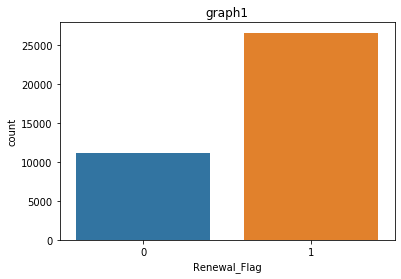

In [6]:
# Bar plot to see the distribution of instances when contracts were renewed by the partners
sns.countplot('Renewal_Flag', data = ads)
plt.title("graph1")

Text(0.5, 1.0, 'graph5')

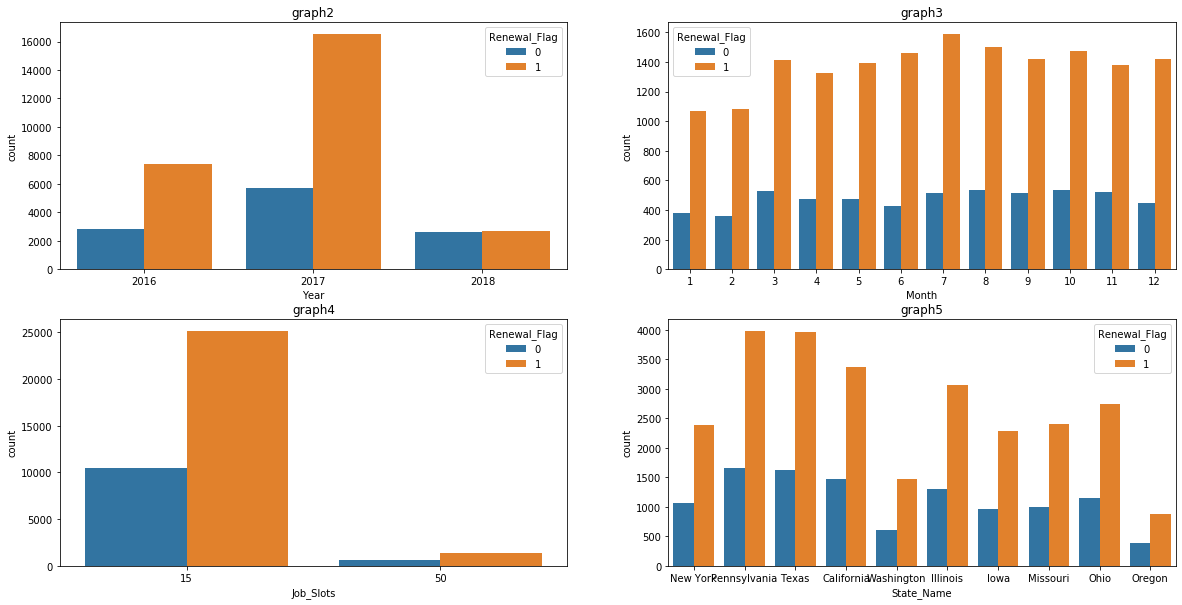

In [7]:
#Plotting distribution of Renewal instances across other fields
#Renewal vs Year, to see if change in year had an impact on number of renewals
plt.figure(figsize = (20,10))
plt.subplot(2,2,1)
sns.countplot('Year', hue = 'Renewal_Flag', data = ads)
plt.title("graph2")

#Renewal vs Months, Looked across months for year 2017 as from the previous graph we see that- 
#2017 witnessed high renewals and more number of purchases compared to 2016. 
plt.subplot(2,2,2)
sns.countplot('Month', hue = 'Renewal_Flag', data = ads.loc[ads['Year']== 2017], )
plt.title("graph3")

#Job Slots vs Renewals, Treating Job Slots as a categorical variable 
#(Assuming Job slots are sold in only these two figures 15 and 50)
plt.subplot(2,2,3)
sns.countplot('Job_Slots', hue = 'Renewal_Flag', data = ads )
plt.title("graph4")

#renewals vs States, to check if any certain State has higher retention than others.
plt.subplot(2,2,4)
sns.countplot('State_Name', hue = 'Renewal_Flag', data = ads )
plt.title("graph5")

Text(0.5, 1.0, 'graph6')

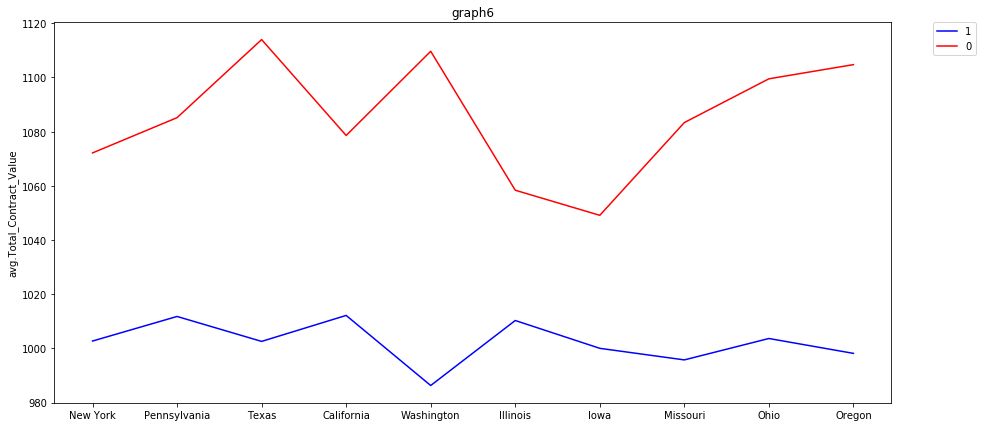

In [8]:
#Plotting the avg. Total_Contract_Value for renewal and non-renewal instances across states
a = ads.loc[ads['Renewal_Flag']== 1].groupby(['State_Name']).mean()

y1 = a['Total_Contract_Value']

b = ads.loc[ads['Renewal_Flag']== 0].groupby(['State_Name']).mean()
y2 = b['Total_Contract_Value']
x = pd.unique(ads['State_Name'])
plt.figure(figsize = (15,7))
plt.plot(x,y1, "b", label = "1")
plt.plot(x,y2, "r", label = "0")
plt.ylabel("avg.Total_Contract_Value")
plt.legend(bbox_to_anchor = (1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("graph6")

Text(0.5, 1.0, 'graph7')

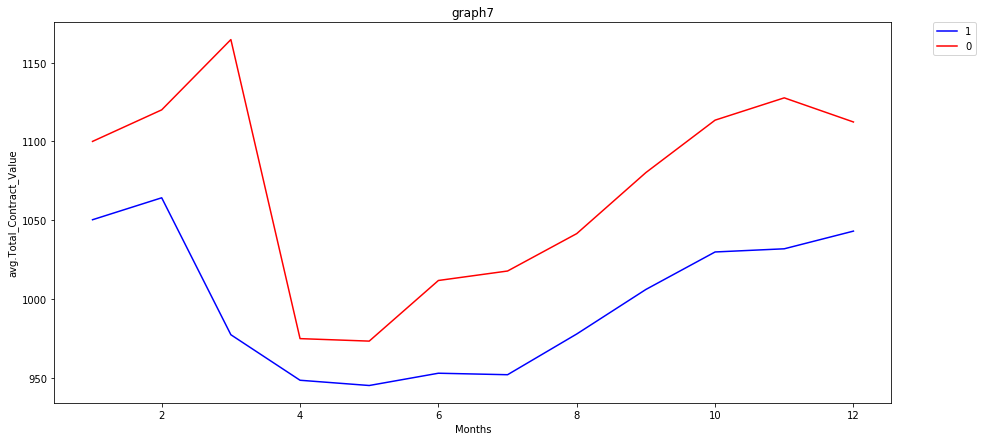

In [9]:
#Plotting avg.Total_Contract_Value for renewal and non-renewal instances across months
a = ads.loc[ads['Renewal_Flag']== 1].groupby(['Month']).mean()

y1 = a['Total_Contract_Value']

b = ads.loc[ads['Renewal_Flag']== 0].groupby(['Month']).mean()
y2 = b['Total_Contract_Value']
x = list(range(1,13))

plt.figure(figsize = (15,7))
plt.plot(x,y1, "b", label = "1")
plt.plot(x,y2, "r", label = "0")
plt.ylabel("avg.Total_Contract_Value")
plt.xlabel("Months")
plt.legend(bbox_to_anchor = (1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("graph7")

Conclusions:
1. From graph 2 and 3, we can conclude that retention is affected by months and year change. It can be an indirect factor affecting retention for example: Number of job openings are increasing over the year so more companies are purchasing job slots. Also during fall and winter period, large number of people seek for job opportunities part-time/full-time resulting companies wanting to achieve maximum applicants coverage by purchasing or renewing job slot contracts.
2. For the two job-slot categories i.e 15 and 50, we see in graph 4 that the amount of purchased contracts and renewals are much higher for the 15 slot group.
3. From the graph 6 and 7, we can tell that the average total_Contract_Value for the non-renewable instances is higher than the renewed ones. And this pattern is persists across both states and months.

### Prediction Model
To identify the combination of factors that best predict the likelihood to retention or renewal, we can build a Logistic Regression model with 'Renewal_Flag' as our binary classifier. 

In [10]:
#Selecting the predictor variables from the analytical data set for the model. 
#Excluding fields: Contract_ID, StartDate, EndDate, City_Name, State_Name, State_ID

predictors = ['Employer_ID','City_ID','Contract_Duration','Job_Slots','Total_Contract_Value','Applications','Apply_Start_Clicks','Click_Market_Value','Job_Listings','Month','Year']
#Creating the predictor variable dataframe and response variable dataframe
X = sales_perf_data.loc[:, sales_perf_data.columns.isin(predictors)]

Y = sales_perf_data['Renewal_Flag']



[1.12532025e+03 1.90315113e+00 2.63530826e+04 1.15464832e+01
 2.03934340e+02 1.52253855e+02 2.52917411e+02 5.32908738e+02
 1.05114754e+01 2.37803087e+02 5.03771351e+02]


C:\Users\Frost\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


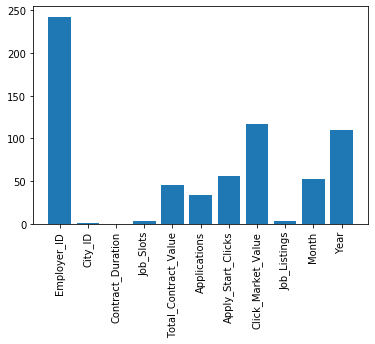

In [11]:
# feature extraction

#Performing this step to find the most significant variables as predictors for our model
test = SelectKBest(score_func=f_classif, k=5)
fit = test.fit(X, Y)

# summarize scores
print(fit.scores_)

scores = -np.log10(fit.pvalues_)

#Plotting scores to see which features are best
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

As seen from the EDA, Month and Year are important features, along with Total_Contract_Value, Click_Market_Value, Apply_Click_Starts and Employer_ID.

In [19]:
#Selecting the most important features as predictors for the model
imp_predictors = ['Click_Market_Value','Employer_ID','Month','Year','Apply_Start_Clicks','Total_Contract_Value']

#dividing the data into training and test datasets. 80% data as training data and 20% as test data.
X_new = X.loc[:, X.columns.isin(imp_predictors)]
X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size = 0.20)

##### Logistic Regression Model

In [20]:
#Logistic Regression Model:

logmodel1 = LogisticRegression(C = 0.1, penalty = 'l1', solver = 'liblinear', max_iter = 10000)
logmodel1.fit(X_train, Y_train)
 
predictions = logmodel1.predict(X_test)
print(classification_report(Y_test, predictions))
print(confusion_matrix(Y_test, predictions))
print(accuracy_score(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.72      0.15      0.24      2232
           1       0.73      0.98      0.84      5320

    accuracy                           0.73      7552
   macro avg       0.73      0.56      0.54      7552
weighted avg       0.73      0.73      0.66      7552

[[ 329 1903]
 [ 126 5194]]
0.7313294491525424


Text(0.5, 257.44, 'Predicted')

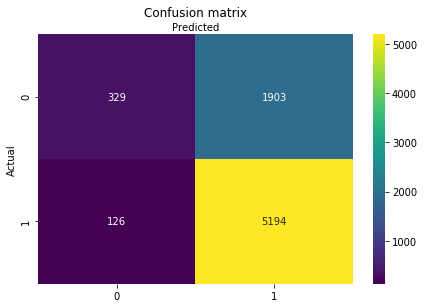

In [21]:
#Plotting the confusion matrix heatmap
cnf_matrix = confusion_matrix(Y_test, predictions)

class_names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="viridis" ,fmt='d')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

##### Results:
1. Accuracy of the model: 73.13%
2. Confusion matrix: The model is able to predict renewal cases with with high accurace but is also predicting majority of non-renewals as renewals. The accuracy of the model for predicting retention is good but the high false-positives is a concern. This might be because of the less number of data for non-renewals in the sample.

##### Decision Tree Classifier Model

Decision tree classifier can also be used as a binary classifier prediction model. 
Using Decision tree on the same training and test datasets to compare its results with the Logistic model

In [22]:
#Using Gini Index criterion for the dicision tree classifier
dt_clf_gini = DecisionTreeClassifier(criterion = "gini", max_depth=10)
dt_clf_gini.fit(X_train, Y_train)

dt_pred = dt_clf_gini.predict(X_test)
print("Predicted values:")
print("Confusion Matrix: ", confusion_matrix(Y_test, dt_pred)) 
print ("Accuracy : ", accuracy_score(Y_test,dt_pred)*100) 
print("Report : ", classification_report(Y_test, dt_pred)) 

Predicted values:
Confusion Matrix:  [[ 899 1333]
 [ 408 4912]]
Accuracy :  76.94650423728814
Report :                precision    recall  f1-score   support

           0       0.69      0.40      0.51      2232
           1       0.79      0.92      0.85      5320

    accuracy                           0.77      7552
   macro avg       0.74      0.66      0.68      7552
weighted avg       0.76      0.77      0.75      7552



Text(0.5, 257.44, 'Predicted')

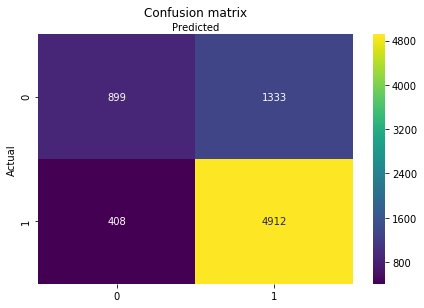

In [23]:
#Plotting the confusion matrix
cnf_matrix_dt = confusion_matrix(Y_test, dt_pred)

class_names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix_dt), annot=True, cmap="viridis" ,fmt='d')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

##### Results:
1. Accuracy of the model: 76.94% for tree depth  = 10
2. Confusion matrix: The model is able to predict renewal cases with with high accuracy. Though the False-positives(predicting actual 0 as 1) is high, it has better recall than the Logistic model. 

### Conclusion:


##### Factors:
The factors that best predict likelihood to retention or renewal are:
1. Click Market Value
2. Apply Start Clicks
3. Total Contract Value
4. Applications
5. Employer_ID

Assumptions taken: 
1. Job Slots are sold in two packages: 15 slot and 50 slot.
2. Total_Contract_Value is the selling price of the job slot contract defined by Glassdoor that the client must pay.
3. Considering Total_Contract_Value as the income revenue for Glassdoor through selling job slot contracts.


##### Model Prediction:
I tested two models to see which will better predict the likelihood of renewal of contract.
1. Logistic Regression Model: 
    Overall accuracy of the model is: 73.13%
    Even thouogh it is able to predict renewals well enough, it is falsely predicting cases of non-renewal as renewal which can be misleading. 
2. Decision Tree Classifier:
    Overall accuracy of the model is: 76.94%
    It is able to predict renewal instances as well as non-renewal instances bettwr than the Logistic model.

##### Additional Factors:
In addition to the factors available, I would like to investigate Employer details such as industry type or job listing descriptions. I think certain industry sectors are more competitive and job openings than others and so are highly sought after by the applicants. I would like to investigate fields or factors contributing towards the Total_Contract_Value of a contract.
##### Recommendation:
1. Reducing the selling price of the contract, as the average selling price of contracts(Total_Contract_Value) for renewed instances is lower than the non-renewed ones. Thus it can improve retention rates.
2. Remove 50 slot group, and use those slots to create more 15 slot groups which are much more preferred by the employers.According to the data, Total contract cost of these 50 slot groups is higher which leads to less employers opting for it and also not renewing the contract. Also the total revenue generated by the 50 slot group is much less to that of the 15 slot groups.